In [24]:
from scipy.io import loadmat
import numpy as np

data = loadmat('dataBenchmark.mat')

u_est = np.squeeze(data['uEst'])
y_est = np.squeeze(data['yEst'])
u_val = np.squeeze(data['uVal'])
y_val = np.squeeze(data['yVal'])

In [25]:
scale_parameter = np.abs(np.max(u_est))
u_est /= scale_parameter
u_val /= scale_parameter

In [26]:
kernels = (100, 100, 20)
R = 25

model_order = len(kernels)
model_memory_len = np.max(kernels)

In [27]:
N_tab = [256, 384, 512, 640, 768, 896, 1024]
N_tab = [1024]

In [28]:
import numpy as np
from entropic_descent import *
from aggregation import *

import time

max_sys_output = np.max(np.abs(y_est))
max_model_output = R
G_sq = (max_model_output + max_sys_output) ** 2 * R ** 2
G_sq_scaled = 4 * G_sq

e_da = {}
e_da_scaled = {}
e_aggr = {}

y_mod_da = 0
y_mod_da_scaled = 0
y_mod_aggr = 0

for N in N_tab:
    print("Number of measurements: {0}".format(N))
    
    x = u_est[model_memory_len - 1 : N - 1]
    x0 = u_est[0 : model_memory_len - 1]
    y = y_est[model_memory_len - 1 : N - 1]
    
    # DA
    m_da = VolterraModel(kernels=kernels)
    alg = AdaptiveLazyEntropicDescentAlgorithm(m_da.dictionary, R=R, constraint='ball')
    start = time.time()
    da_parameters = alg.run(x, y, G_sq, x0=x0)
    end = time.time()
    print('time: {0}'.format(end - start))
    
    # validate
    m_da.set_parameters(da_parameters)
    y_mod_da = m_da.evaluate_output(u_val)
    e_da[N] = 1 / len(u_val) * np.sum((y_mod_da - y_val) ** 2)
    
    # # DA scaled
    # m_da_scaled = VolterraModel(kernels=kernels)
    # alg_scaled = AdaptiveLazyEntropicDescentAlgorithm(m_da_scaled.dictionary, R=R, constraint='ball')
    # da_scaled_parameters = alg_scaled.run(x, y, G_sq_scaled, x0=x0)
    # 
    # # validate
    # m_da_scaled.set_parameters(da_scaled_parameters)
    # y_mod_da_scaled = m_da_scaled.evaluate_output(u_val)
    # e_da_scaled[N] = 1 / len(u_val) * np.sum((y_mod_da_scaled - y_val) ** 2)

    # aggregation
    m_aggr = VolterraModel(kernels=kernels)
    start = time.time()
    aggr_parameters = aggregation_for_volterra(m_aggr.dictionary, x, y, x0=x0, R=R)
    end = time.time()
    print('time: {0}'.format(end - start))
    
    # validate
    m_aggr.set_parameters(aggr_parameters)
    y_mod_aggr = m_aggr.evaluate_output(u_val)
    e_aggr[N] = 1 / len(u_val) * np.sum((y_mod_aggr - y_val) ** 2)


print(e_da)
print(e_aggr)
print(e_da_scaled)

100%|██████████| 924/924 [05:36<00:00,  2.74it/s]


Number of measurements: 1024
time: 336.9587082862854
time: 459.1141526699066
{1024: 1.4594055754256594}
{1024: 1.101105958546409}
{}


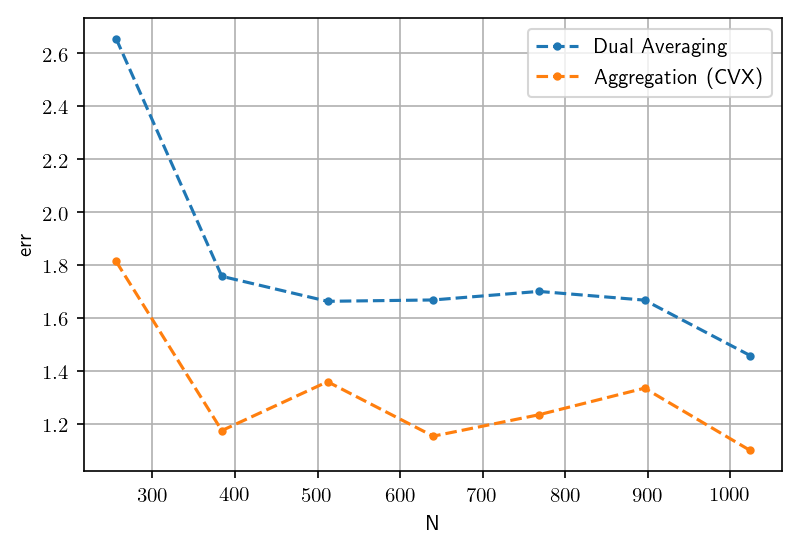

In [29]:
N_tab = [256, 384, 512, 640, 768, 896, 1024]
e_da = {256: 2.655826174935653, 384: 1.7586809888358308, 512: 1.669418094558463, 640: 1.7016957417761547, 768: 1.6687222543707252, 896: 1.664319108446953, 1024: 1.4594055754256594}
e_aggr = {256: 1.8146420296318522, 384: 1.1763044560015317, 512: 1.1551906257363689, 640: 1.2360096057384065, 768: 1.3364090918593552, 896: 1.360749047310269, 1024: 1.101105958546409}
e_da_scaled = {256: 4.3822738649650415, 384: 1.651323480778825, 896: 1.549978460619951, 512: 1.5742964705870213, 640: 1.600210270709306, 768: 1.5875392723840456, 1024: 1.3442783463487125}

import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 150
plt.rcParams['text.usetex'] = True
plt.plot(N_tab, e_da.values(), '--.')
plt.plot(N_tab, e_aggr.values(), '--.')
plt.xlabel('N')
plt.ylabel('err')
plt.legend(['Dual Averaging', 'Aggregation (CVX)'])
plt.grid()
plt.show()

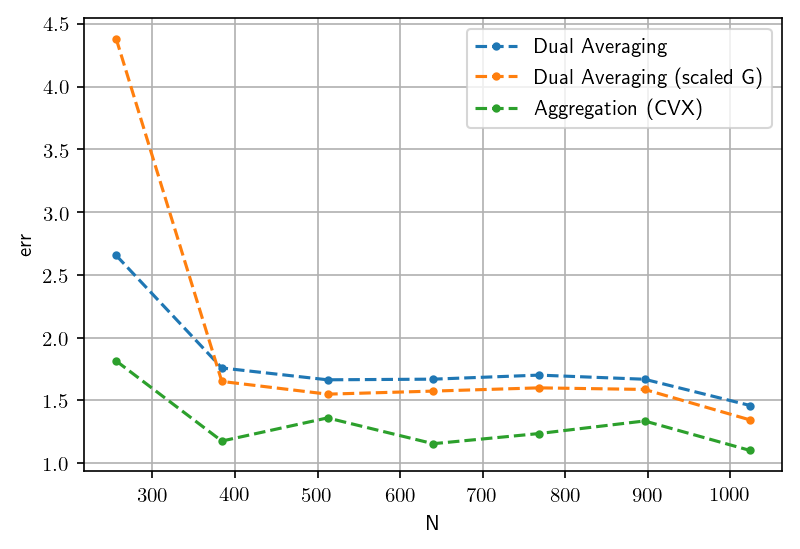

In [30]:
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 150
plt.plot(N_tab, e_da.values(), '--.')
plt.plot(N_tab, e_da_scaled.values(), '--.')
plt.plot(N_tab, e_aggr.values(), '--.')
plt.xlabel('N')
plt.ylabel('err')
plt.legend(['Dual Averaging', 'Dual Averaging (scaled G)', 'Aggregation (CVX)'])
plt.grid()
plt.show()
    

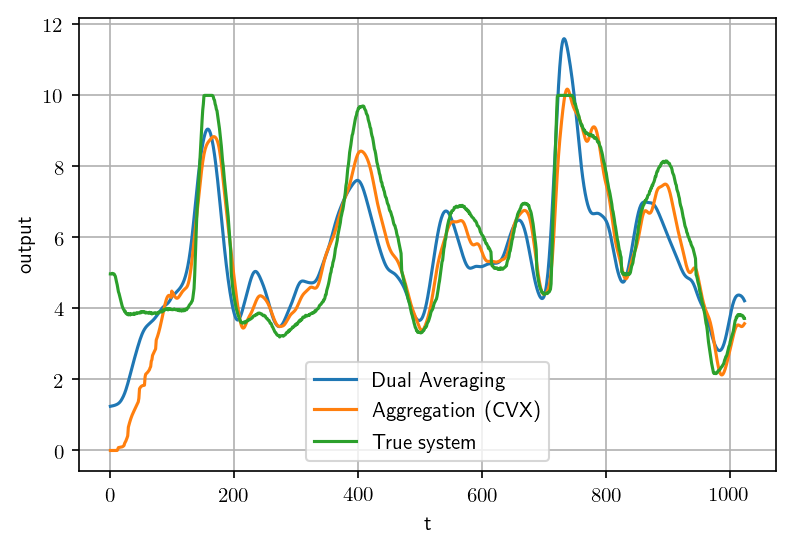

In [31]:
import matplotlib.pyplot as plt
plot_output = True

if plot_output:
    plt.rcParams['figure.dpi'] = 150
    plt.plot(y_mod_da)
    plt.plot(y_mod_aggr)
    plt.plot(y_val)
    plt.xlabel('t')
    plt.ylabel('output')
    plt.legend(['Dual Averaging', 'Aggregation (CVX)', 'True system'])
    plt.grid()
    plt.show()
    

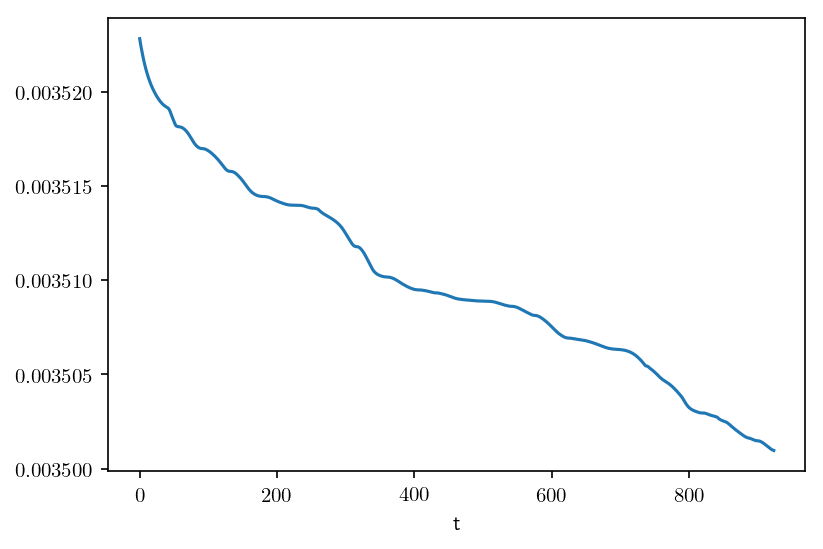

In [32]:
import matplotlib.pyplot as plt
plot_stepsizes = True

if plot_stepsizes:
    plt.rcParams['figure.dpi'] = 150
    plt.plot(alg.stepsize_seq)
    plt.xlabel('t')
    plt.show()


In [33]:
# import pickle
# with open('benchtank_vars', 'wb') as f:
#     pickle.dump([y_val, y_mod_da, y_mod_aggr, da_parameters, aggr_parameters], f)